In [34]:
import multiprocessing
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from datasets import Dataset, Features, Image, load_dataset
from PIL import Image as PILImage
from PIL import ImageFilter
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import sobel
from skimage.measure import shannon_entropy
from sklearn.model_selection import train_test_split
from tqdm import tqdm

tqdm.pandas()

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [144]:
# Pedro's data path to files
data_path = "/Users/pemujo/Downloads/GLDv2"

In [2]:
data_path = "../../../../../data/"

In [10]:
!pwd

/home/jupyter/gcs/personal_projects/vit-gldv2


In [3]:
# Load data

kaggle_train_image_ids = pd.read_csv(
    f"{data_path}/kaggle_train.csv"
)  # File path to download https://www.kaggle.com/competitions/landmark-recognition-2021/data?select=train.csv
full_train_image_ids = pd.read_csv(
    f"{data_path}/train_full.csv"
)  # File path to download https://s3.amazonaws.com/google-landmark/metadata/train.csv
train_label_to_category = pd.read_csv(
    f"{data_path}/train_label_to_category.csv"
)  # File path to download https://s3.amazonaws.com/google-landmark/metadata/train_label_to_category.csv

In [4]:
# Filtered the Google train set to get the URL of the images including only the ids that are in the Kaggle dataset (used pandas.isin feature)
# Then joined with the landmark to category to know which category is each and also include the URL to the category

join_w_landmark_id = full_train_image_ids[
    full_train_image_ids.id.isin(kaggle_train_image_ids.id.values)
].join(train_label_to_category, on=["landmark_id"], how="left", rsuffix="_right")
join_w_landmark_id = join_w_landmark_id.drop(
    ["landmark_id_right"], axis=1
)  # Dropped the right landmark_id column

# Split the category url into category and category_url
join_w_landmark_id = join_w_landmark_id.rename(columns={"category": "category_url"})
join_w_landmark_id["category"] = join_w_landmark_id["category_url"].apply(
    lambda x: str(x).split("Category:", 1)[1]
)

join_w_landmark_id.drop(columns=["url", "category_url"], inplace=True)

In [5]:
join_w_landmark_id.head()

,id,landmark_id,category
1,202cd79556f30760,104169,Stirling_Castle
3,e7f70e9c61e66af3,102140,Estadio_Deportivo_Cali
6,6f31b874d1a4d489,6888,Livadiiskyi_Park
8,3968e37e503f3109,122849,Wildensbuch_lookout_tower
12,88f3f71c2b71a6f9,198623,"Newark_Castle,_Nottinghamshire"


In [6]:
# Overal numbers
print(f"Total number of images: {len(join_w_landmark_id)}")
print(f"Total number of categories : {len(join_w_landmark_id.landmark_id.unique())}")

min_image_count = 100

image_count_by_category = (
    join_w_landmark_id.groupby(["landmark_id", "category"])["id"]
    .count()
    .sort_values(ascending=False)
    .value_counts()
    .to_dict()
)

categories_with_more_than_min = {
    k: v for k, v in image_count_by_category.items() if k > min_image_count
}

categories_count = sum(categories_with_more_than_min.values())
print(f"Categories with more than {min_image_count} images: {categories_count}")

Total number of images: 1580470
Total number of categories : 81313
Categories with more than 100 images: 1971


<function matplotlib.pyplot.show(close=None, block=None)>

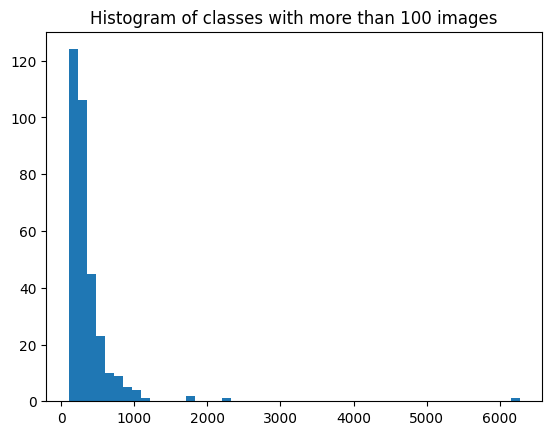

In [7]:
plt.hist(categories_with_more_than_min, bins=50)
plt.title(f"Histogram of classes with more than {min_image_count} images")
plt.show

In [8]:
join_w_landmark_id.groupby(["landmark_id", "category"])["id"].count().sort_values(
    ascending=False
)[:categories_count]

landmark_id  category                                              
138982       Media_contributed_by_the_ETH-Bibliothek                   6272
126637       Corktown,_Toronto                                         2231
20409        Noraduz_Cemetery                                          1758
83144        Museum_of_Folk_Architecture_and_Ethnography_in_Pyrohiv    1741
113209       Sal%C3%A8ve                                               1135
                                                                       ... 
83547        Sint_Petrus_Banden_(Oirschot)                              101
162547       Saint_Peter's_Church,_Riga                                 101
138853       Ibitipoca                                                  101
47304        Abtei_Plankstetten                                         101
32104        City_walls_of_Provins                                      101
Name: id, Length: 1971, dtype: int64

In [9]:
# Get list of categories with more than the minimum number of images (500)
main_df = join_w_landmark_id.groupby("landmark_id").filter(
    lambda x: len(x) > min_image_count
)
main_df["landmark_id"].value_counts()

138982    6272
126637    2231
20409     1758
83144     1741
113209    1135
          ... 
188329     101
182198     101
46503      101
8161       101
164019     101
Name: landmark_id, Length: 1971, dtype: int64

In [10]:
main_df

,id,landmark_id,category
25,3cdc355c6232712f,12877,Columbarium_of_the_P%C3%A8re-Lachaise_Cemetery
65,1a70f92ba679fac0,77563,Feofaniya_Park
89,b097f639658778d4,169256,Castle_To%C4%8Dn%C3%ADk
91,8536cce9c8deb3fe,138982,Media_contributed_by_the_ETH-Bibliothek
122,bbc76dae2d3bef4d,17358,Ponte_25_de_Abril
...,...,...,...
4132801,e4f8f4f50846b89b,112481,Shalvan_Vihara
4132817,a85f84f2b35ae895,194406,Dayr-e_Gachin
4132822,c6b2cb2e48f59019,83144,Museum_of_Folk_Architecture_and_Ethnography_in...
4132825,0de86a6824dd3906,158818,Khor_Virap


In [11]:
class_count = main_df["landmark_id"].nunique()
class_count

1971

In [12]:
# Add path to local image
def get_image_path(image_id):
    # Gets image_id string with the filder prexix included in the name
    # Returns numpy array with image and local path

    f1 = image_id[0]
    f2 = image_id[1]
    f3 = image_id[2]
    image_path = f"{data_path}train/{f1}/{f2}/{f3}/{image_id}.jpg"
    return image_path


main_df["image_path"] = join_w_landmark_id["id"].parallel_apply(get_image_path)

In [13]:
main_df

,id,landmark_id,category,image_path
25,3cdc355c6232712f,12877,Columbarium_of_the_P%C3%A8re-Lachaise_Cemetery,../../../../../data/train/3/c/d/3cdc355c623271...
65,1a70f92ba679fac0,77563,Feofaniya_Park,../../../../../data/train/1/a/7/1a70f92ba679fa...
89,b097f639658778d4,169256,Castle_To%C4%8Dn%C3%ADk,../../../../../data/train/b/0/9/b097f639658778...
91,8536cce9c8deb3fe,138982,Media_contributed_by_the_ETH-Bibliothek,../../../../../data/train/8/5/3/8536cce9c8deb3...
122,bbc76dae2d3bef4d,17358,Ponte_25_de_Abril,../../../../../data/train/b/b/c/bbc76dae2d3bef...
...,...,...,...,...
4132801,e4f8f4f50846b89b,112481,Shalvan_Vihara,../../../../../data/train/e/4/f/e4f8f4f50846b8...
4132817,a85f84f2b35ae895,194406,Dayr-e_Gachin,../../../../../data/train/a/8/5/a85f84f2b35ae8...
4132822,c6b2cb2e48f59019,83144,Museum_of_Folk_Architecture_and_Ethnography_in...,../../../../../data/train/c/6/b/c6b2cb2e48f590...
4132825,0de86a6824dd3906,158818,Khor_Virap,../../../../../data/train/0/d/e/0de86a6824dd39...


In [24]:
main_df.to_csv(f"./GLDv2_classes_more than_50_images.csv")

In [15]:
# Reducing size to 224x224 for Transformer


# this will make all images 224x224
def normalize_images(image_path):
    dimensions = (224, 224)
    im = Image.open(image_path)
    width = im.width
    height = im.height

    if width > 800 or height > 800:
        im = im.filter(filter=ImageFilter.BLUR)
        im = im.resize((width / 2, height / 2))
        im = im.filter(filter=ImageFilter.BLUR)
        im = im.resize(dimensions)
    if width > 400 or height > 400:
        im = im.filter(filter=ImageFilter.BLUR)
        im = im.resize(dimensions)

    im = im.resize(dimensions)

    return im


main_df["image"] = main_df["image_path"].parallel_apply(normalize_images)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

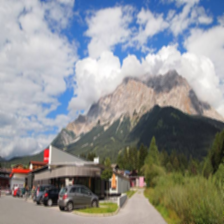

In [17]:
main_df.iloc[45577]["image"]

In [ ]:
main_df.to_pickle("./GLDv2_classes_more_than_100_images.pkl")

In [53]:
# Load the pandas dataframe from pickle file
local_path = "./"
train_df, validation_df = train_test_split(
    main_df, test_size=0.2, random_state=42, shuffle=True
)


# Convert pandas to dic (Load directly from pandas never worked with error: ArrowInvalid: Can only convert 1-dimensional array values)
validation_dict = validation_df.to_dict(orient="list")

# Training dataset
train_dict = train_df.to_dict(orient="list")

In [36]:
# This step required a lot of memory it crahsed a VM wth 30GB of RAM for the train Dataset so I had to do it in batches of 1000 images
test_hugging_dataset = Dataset.from_dict(validation_dict).cast_column("image", Image())

In [57]:
train_hugging_dataset

Dataset({
    features: ['id', 'landmark_id', 'category', 'image_path', 'image', 'label'],
    num_rows: 292848
})

In [39]:
# Save test dataset to disk
test_hugging_dataset.save_to_disk(
    "./hugging_face/GLDv2_classes_more_than_100_images_validation_dataset.hf"
)

Saving the dataset (0/10 shards):   0%|          | 0/73212 [00:00<?, ? examples/s]

In [43]:
train_hugging_dataset = Dataset.from_dict(train_dict).cast_column("image", Image())

In [47]:
# Save full training dataset to disk
train_hugging_dataset.save_to_disk(
    "./hugging_face/GLDv2_classes_more_than_100_images_train_dataset.hf"
)

Saving the dataset (0/40 shards):   0%|          | 0/292848 [00:00<?, ? examples/s]

In [80]:
# Once the datasets are saved it can be loaded directly from disk
dataset_train = Dataset.load_from_disk("./hugging_face/top51_hugging_train_dataset.hf")
dataset_validation = Dataset.load_from_disk(
    "./hugging_face/top51_hugging_validation_dataset.hf"
)

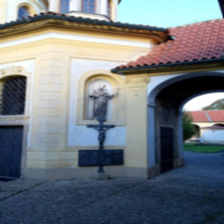

In [53]:
test_hugging_dataset[9115]["image"]

In [56]:
test_hugging_dataset

Dataset({
    features: ['id', 'landmark_id', 'category', 'image_path', 'image', 'label'],
    num_rows: 73212
})

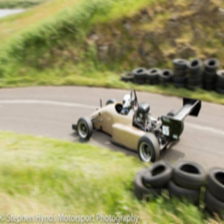

In [50]:
train_hugging_dataset[362]["image"]

In [54]:
# # ViT model needs labels to start from 0 so I had to add a 'label' column to the datasets
label = [x for x in range(class_count)]
landmarks = list(set(train_hugging_dataset["landmark_id"]))
label_map_landmark_id = dict(zip(landmarks, label))
landmark_id_map_label = dict(zip(label, landmarks))


def add_label(example):
    # print(example)
    example["label"] = label_map_landmark_id[example["landmark_id"]]
    return example


train_hugging_dataset = train_hugging_dataset.map(add_label)
test_hugging_dataset = test_hugging_dataset.map(add_label)

Map:   0%|          | 0/73212 [00:00<?, ? examples/s]

In [58]:
train_hugging_dataset.save_to_disk(
    "./hugging_face/GLDv2_classes_more_than_100_images_train_dataset.hf"
)
test_hugging_dataset.save_to_disk(
    "./hugging_face/GLDv2_classes_more_than_100_images_validation_dataset.hf"
)

Saving the dataset (0/40 shards):   0%|          | 0/292848 [00:00<?, ? examples/s]

Saving the dataset (0/10 shards):   0%|          | 0/73212 [00:00<?, ? examples/s]

In [87]:
category_landmark_id = dict(
    validation_df.groupby("category")
    .apply(lambda df: df.sample(1))[["landmark_id", "category"]]
    .values.tolist()
)
category_landmark_id

{85633: '%C3%87ufut_Qale',
 152708: "Akbar's_Tomb",
 41648: 'Akkerman_fortress',
 20120: 'Catedral_San_Sebasti%C3%A1n,_Cochabamba',
 126637: 'Corktown,_Toronto',
 41808: 'Douthat_State_Park',
 165596: 'Edinburgh_Castle',
 47378: 'Eiffel_Tower',
 80177: 'Episcopal_Diocese_of_Southwest_Florida',
 190822: 'Faisal_Mosque',
 9070: 'Feroz_Shah_Kotla',
 187779: 'Genoese_fortress_(Sudak)',
 168098: 'Golden_Gate_Bridge',
 46705: 'Grand_Canyon',
 51856: 'Grote_of_Onze-Lieve-Vrouwekerk_(Breda)',
 191292: 'Haghpat',
 176528: 'Haleakal%C4%81_National_Park',
 143710: 'Harichavank',
 176018: 'Hayravank_monastery',
 27: "Isa_Khan_Niyazi's_tomb",
 189907: "Itmad-Ud-Daulah's_Tomb",
 31531: 'Jurassic_Coast',
 36748: 'Kecharis',
 149980: 'Khotyn_Fortress',
 189811: 'Lake_Como',
 101399: 'Ljubljana_Castle',
 177870: 'Lviv',
 161902: 'Madrid_R%C3%ADo',
 40088: 'Masada',
 120734: 'Mathura_Museum',
 25093: 'Matka_Canyon',
 138982: 'Media_contributed_by_the_ETH-Bibliothek',
 83144: 'Museum_of_Folk_Architecture

In [88]:
# Once created can be pulled directly from code:

# category_landmark_id = {41648: 'Akkerman_fortress',
#  20120: 'Catedral_San_Sebasti%C3%A1n,_Cochabamba',
#  165596: 'Edinburgh_Castle',
#  47378: 'Eiffel_Tower',
#  9070: 'Feroz_Shah_Kotla',
#  187779: 'Genoese_fortress_(Sudak)',
#  168098: 'Golden_Gate_Bridge',
#  46705: 'Grand_Canyon',
#  176528: 'Haleakal%C4%81_National_Park',
#  176018: 'Hayravank_monastery',
#  36748: 'Kecharis',
#  149980: 'Khotyn_Fortress',
#  161902: 'Madrid_R%C3%ADo',
#  120734: 'Mathura_Museum',
#  1924: 'Niagara_Falls',
#  139894: 'Pe%C5%A1ter',
#  10419: 'Qutb_Minar_and_its_monuments,_Delhi',
#  38482: 'Skopje_Fortress',
#  45428: 'Sofiyivsky_Park',
#  14915: 'St._Lawrence,_Toronto'}

label = [x for x in range(class_count)]
landmarks = list(set(dataset_train["landmark_id"]))
label_map_landmark_id = dict(zip(landmarks, label))
landmark_id_map_label = dict(zip(label, landmarks))

In [89]:
# Test label to category name mapping
def get_category_name(label):
    return category_landmark_id[landmark_id_map_label[label]]


test_label = 1
print(f"Label: {test_label} --> Category: {get_category_name(1)}")

Label: 1 --> Category: Genoese_fortress_(Sudak)


In [92]:
# Validate all entries are still there
z = dataset_train["label"]
Counter(z).most_common()

[(42, 5043),
 (22, 1784),
 (29, 1392),
 (33, 1387),
 (28, 924),
 (34, 892),
 (41, 865),
 (2, 786),
 (50, 768),
 (38, 768),
 (45, 740),
 (11, 735),
 (19, 723),
 (15, 722),
 (46, 710),
 (44, 682),
 (5, 665),
 (9, 658),
 (18, 647),
 (26, 620),
 (31, 611),
 (49, 605),
 (1, 595),
 (24, 594),
 (10, 584),
 (36, 571),
 (39, 569),
 (13, 541),
 (32, 539),
 (3, 528),
 (8, 519),
 (30, 485),
 (37, 484),
 (43, 483),
 (20, 471),
 (6, 469),
 (35, 453),
 (7, 449),
 (47, 446),
 (48, 442),
 (17, 432),
 (12, 426),
 (14, 419),
 (27, 418),
 (25, 418),
 (40, 415),
 (21, 410),
 (4, 398),
 (0, 398),
 (23, 396),
 (16, 384)]

In [102]:
dataset_validation

Dataset({
    features: ['id', 'landmark_id', 'category', 'image', 'label'],
    num_rows: 9116
})

In [97]:
dataset_train = dataset_train.remove_columns("image_path")
dataset_validation = dataset_validation.remove_columns("image_path")

In [103]:
dataset_train

Dataset({
    features: ['id', 'landmark_id', 'category', 'image', 'label'],
    num_rows: 36463
})

In [101]:
dataset_train.save_to_disk("./hugging_face/main_top51_hugging_train_dataset.hf")
dataset_validation.save_to_disk(
    "./hugging_face/main_top51_hugging_validation_dataset.hf"
)

Saving the dataset (0/5 shards):   0%|          | 0/36463 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/9116 [00:00<?, ? examples/s]

In [104]:
# Once the datasets are saved it can be loaded directly from disk
dataset_train = Dataset.load_from_disk(
    "./hugging_face/main_top51_hugging_train_dataset.hf"
)
dataset_validation = Dataset.load_from_disk(
    "./hugging_face/main_top51_hugging_validation_dataset.hf"
)

In [105]:
dataset_validation

Dataset({
    features: ['id', 'landmark_id', 'category', 'image', 'label'],
    num_rows: 9116
})

In [106]:
dataset_train

Dataset({
    features: ['id', 'landmark_id', 'category', 'image', 'label'],
    num_rows: 36463
})